In [31]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [32]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(5581, 18)
['Unnamed: 0', 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


In [33]:
data.head()

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,0,41,services,married,unknown,no,88,yes,no,cellular,11,may,105,1,336,2,failure,no
1,1,56,technician,married,secondary,no,1938,no,yes,cellular,26,feb,229,1,192,4,success,yes
2,2,30,services,single,secondary,no,245,no,yes,cellular,8,jul,187,2,-1,0,unknown,no
3,3,34,management,single,tertiary,no,1396,yes,no,cellular,17,jul,630,1,-1,0,unknown,no
4,4,29,technician,single,secondary,no,-13,yes,no,cellular,14,may,512,3,-1,0,unknown,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [34]:
data['education'].unique()

array(['unknown', 'secondary', 'tertiary', 'primary'], dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [35]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns.

In [36]:
data['education'].unique()

array(['unknown', 'secondary', 'tertiary', 'primary'], dtype=object)

### Data exploration

In [37]:
data['deposit'].value_counts()

no     2959
yes    2622
Name: deposit, dtype: int64

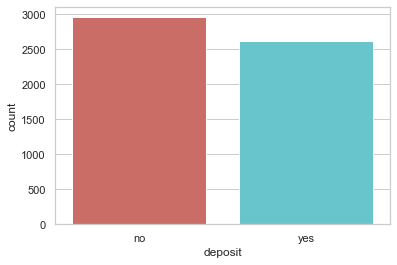

In [38]:
sns.countplot(x='deposit',data=data, palette='hls')
plt.show()

In [39]:
count_no_sub = len(data[data['deposit']==0])
count_sub = len(data[data['deposit']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub+1)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub+1)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 0.0
percentage of subscription 0.0


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. Before we go ahead to balance the classes, Let's do some more exploration.

In [40]:
data.groupby('deposit').mean()

,Unnamed: 0,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,,
no,2766.512335,40.941872,1317.306185,16.165934,219.675228,2.833728,38.343697,0.587699
yes,2816.506484,41.426773,1737.542715,15.160564,535.763158,2.139207,68.548818,1.145309


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [17]:
data.groupby('job').mean()

,Unnamed: 0,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,,
admin.,2827.083207,38.963691,1251.509834,15.385779,350.341906,2.400908,67.358548,0.963691
blue-collar,2751.724103,39.294359,1153.598974,15.197949,382.190769,2.600000,46.429744,0.609231
entrepreneur,2890.581250,43.181250,1280.431250,15.268750,356.356250,2.718750,29.218750,0.537500
housemaid,2822.706294,47.923077,1415.412587,16.454545,305.867133,2.391608,37.055944,0.482517
management,2803.204856,40.303490,1765.643399,15.822458,361.532625,2.628983,53.106980,0.896813
retired,2781.191436,65.322418,2691.420655,15.818640,376.889169,2.007557,56.700252,1.161209
self-employed,2813.830097,39.101942,1805.009709,16.266990,429.771845,2.645631,41.796117,0.713592
services,2847.601770,37.871681,1045.017699,15.995575,395.393805,2.657080,51.221239,0.761062
student,2665.170330,26.434066,1478.456044,15.604396,324.318681,2.115385,67.505495,1.554945


In [41]:
data.groupby('marital').mean()

,Unnamed: 0,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,,
divorced,2857.809826,47.058637,1337.494453,16.023772,373.426307,2.543582,49.106181,0.725832
married,2810.288130,44.730057,1594.575303,15.706445,352.736439,2.595724,50.670708,0.826420
single,2731.425661,32.979075,1438.539648,15.556718,392.996696,2.342511,56.941630,0.932819


In [42]:
data.groupby('education').mean()

,Unnamed: 0,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,,
primary,2753.876676,48.005362,1472.217158,15.095174,371.243968,2.583110,46.135389,0.781501
secondary,2779.464509,40.089371,1308.556455,15.554248,367.347922,2.443178,55.425524,0.831924
tertiary,2812.402459,39.454837,1796.756815,15.950294,372.447889,2.545697,51.181721,0.913415
unknown,2845.832653,45.440816,1778.673469,17.102041,335.400000,2.697959,50.261224,0.767347


Visualizations

Text(0, 0.5, 'Frequency of Purchase')

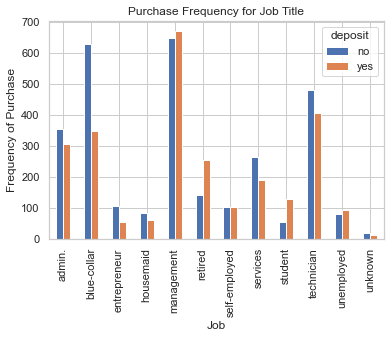

In [21]:
%matplotlib inline
pd.crosstab(data.job,data.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

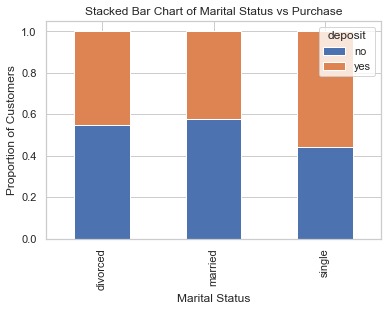

In [22]:
table=pd.crosstab(data.marital,data.deposit)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

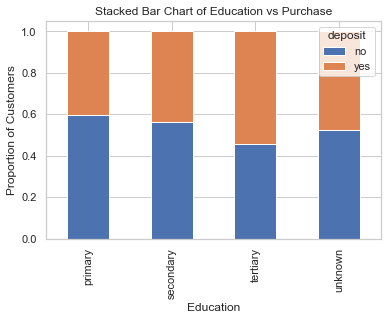

In [23]:
table=pd.crosstab(data.education,data.deposit)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Education seems a good predictor of the outcome variable.

In [43]:
pd.crosstab(data.day_of_week,data.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')

AttributeError: 'DataFrame' object has no attribute 'day_of_week'

Day of week may not be a good predictor of the outcome.

Text(0, 0.5, 'Frequency of Purchase')

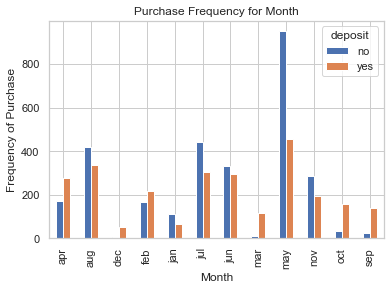

In [44]:
pd.crosstab(data.month,data.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Month might be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency')

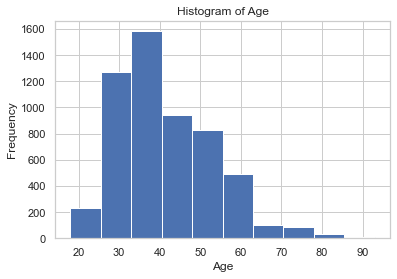

In [26]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most customers of the bank in this dataset are in the age range of 30-40.

Text(0, 0.5, 'Frequency of Purchase')

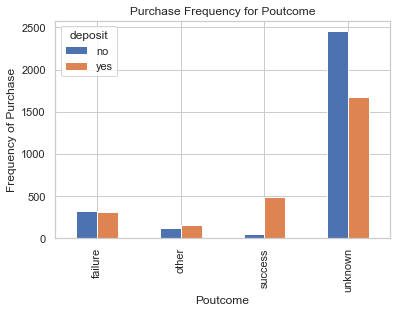

In [27]:
pd.crosstab(data.poutcome,data.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [45]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['Unnamed: 0', 'age', 'balance', 'day', 'duration', 'campaign',
       'pdays', 'previous', 'deposit', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Over-sampling using SMOTE

In [47]:
X = data_final.loc[:, data_final.columns != 'deposit']
y = data_final.loc[:, data_final.columns == 'deposit']

In [48]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['deposit'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['deposit']==0]))
print("Number of subscription",len(os_data_y[os_data_y['deposit']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['deposit']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['deposit']==1])/len(os_data_X))

length of oversampled data is  4114
Number of no subscription in oversampled data 0
Number of subscription 0
Proportion of no subscription data in oversampled data is  0.0
Proportion of subscription data in oversampled data is  0.0


### Recursive feature elimination

In [49]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [50]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True
  True  True  True False False  True  True False False False False  True
 False  True False False  True  True False  True  True  True False False
  True  True  True  True]
[32 29 33 30 28 26 31 27 13 11  6 10 15 23 18 12 22 14 21  4  1  1  1  1
  1  1  1 25 17  1  1 16  8 24  9  1  3  1  7  2  1  1  5  1  1  1 19 20
  1  1  1  1]


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", "poutcome_failure", "poutcome_nonexistent", "poutcome_success".

In [52]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['deposit']

KeyError: "['default_unknown', 'education_illiterate', 'marital_unknown', 'euribor3m'] not in index"

### Implementing the model

In [53]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

TypeError: cannot perform reduce with flexible type

The p-values for four variables are very high, therefore, we will remove them.

In [117]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

In [118]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.555865
         Iterations 7
                           Results: Logit
Model:                Logit             No. Iterations:    7.0000    
Dependent Variable:   y                 Pseudo R-squared:  0.198     
Date:                 2018-09-10 12:38  AIC:               56879.2425
No. Observations:     51134             BIC:               57020.7178
Df Model:             15                Log-Likelihood:    -28424.   
Df Residuals:         51118             LL-Null:           -35443.   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m            -0.4488   0.0074 -60.6837 0.0000 -0.4633 -0.4343
job_blue-collar      -0.2060   0.0278  -7.4032 0.0000 -0.2605 -0.1515
job_housemaid   

### Logistic Regression Model Fitting

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


### Confusion Matrix

In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6124 1542]
 [2505 5170]]


In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.80      0.75      7666
          1       0.77      0.67      0.72      7675

avg / total       0.74      0.74      0.74     15341



#### Interpretation:

Of the entire test set, 74% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 74% of the customer's preferred term deposit were promoted.

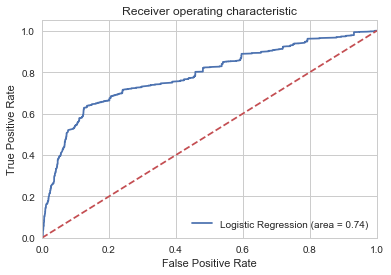

In [124]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()